In [12]:
# reference: https://zenn.dev/ryo_tan/articles/5d03c0157501aa

import os
import sys
if not 'Informer' in sys.path:
    sys.path += ['Informer']

from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

from torch.utils.data import DataLoader
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import yfinance as yf
import requests
import json
import time
import shutil
import matplotlib.pyplot as plt

def remove_directory(dir_path):
    if os.path.exists(dir_path):
        print('removing directory ', dir_path)
        shutil.rmtree(dir_path)

def make_directory(dir_path):
    if not os.path.exists(dir_path):
        print('creating dir ', dir_path)
        os.mkdir(dir_path)

def plot_predictions(trues, preds, start_index, step, num_plots, setting, root_path):
        num_rows = num_plots // 3
        num_cols = 3

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 3 * num_rows), sharex=True, sharey=True)

        for i, ax in enumerate(axes.flatten()):
            if i < num_plots:
                index = start_index + i * step

                ax.plot(trues[index, :, -1], label='GroundTruth')
                ax.plot(preds[index, :, -1], label='Prediction')

                ax.set_title(f'Index {index}')
                ax.legend()
                ax.set_xlabel('time')
                ax.set_ylabel('Realized volatility')
                ax.tick_params(axis='both', which='both', labelsize=8, direction='in')

            else:
                ax.axis('off')


        plt.tight_layout()
        make_directory(os.path.join(root_path, "results_informer"))
        make_directory(os.path.join(root_path, "results_informer", setting))
        plt.savefig(os.path.join(root_path, 'results_informer/'+setting+'/prediction_plot.png'))
        plt.show()
        

def run_volatility(args):    
    args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]
    args.data = 'custom' # data
    # args.root_path =  ROOT_DIR#'/content/' # root path of data file
    args.freq = '1m' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
    args.checkpoints = './informer_checkpoints' # location of model checkpoints
    args.seq_len = 96 # input sequence length of Informer encoder
    args.label_len = 48 # start token length of Informer decoder
    args.pred_len = 24 # prediction sequence length
    # Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]
    args.enc_in = 8 # encoder input size
    args.dec_in = 8 # decoder input size
    args.c_out = 8 # output size
    args.factor = 1 # probsparse attn factor
    args.d_model = 512 # dimension of model
    args.n_heads = 8 # num of heads
    args.d_ff = 2048 # dimension of fcn in model
    args.dropout = 0.05 # dropout
    args.attn = 'prob' # attention used in encoder, options:[prob, full]
    args.embed = 'fixed' # time features encoding, options:[timeF, fixed, learned]
    args.activation = 'gelu' # activation
    args.distil = True # whether to use distilling in encoder
    args.output_attention = False # whether to output attention in ecoder
    args.mix = True
    args.padding = 0
    args.freq = 'h'
    args.batch_size = 32
    args.loss = 'mse'
    args.lradj = 'type1'
    args.use_amp = False # whether to use automatic mixed precision training
    args.num_workers = 0
    args.itr = 1
    args.patience = 100
    args.des = 'exp'
    args.use_gpu = True if torch.cuda.is_available() else False
    args.gpu = 0
    args.use_multi_gpu = False
    args.devices = '0,1,2,3'
    args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False
    args.inverse = False

    if args.use_gpu and args.use_multi_gpu:
        args.devices = args.devices.replace(' ','')
        device_ids = args.devices.split(',')
        args.device_ids = [int(id_) for id_ in device_ids]
        args.gpu = args.device_ids[0]

    # Set augments by using data name
    data_parser = {
        'custom':{'data':args.data_path,
                'T':args.target,
                'M': args.target_config_list_m,
                'S':[1,1,1],
                'MS': args.target_config_list_ms}, #Change the array here based on the number of features
    }
    if args.data in data_parser.keys():
        data_info = data_parser[args.data]
        args.data_path = data_info['data']
        args.target = data_info['T']
        args.enc_in, args.dec_in, args.c_out = data_info[args.features]

    args.detail_freq = args.freq
    args.freq = args.freq[-1:]

    Exp = Exp_Informer
    print('Args in experiment:')
    print(args)

    error_mertics = {}
    losses = None
    setting = ''
    for ii in range(args.itr):
        # setting record of experiments
        setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(
                    args.model_id,
                    args.model, args.data, args.features,
                    args.seq_len, args.label_len, args.pred_len,
                    args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, 
                    args.factor, args.embed, args.distil, args.mix, args.des, ii)

        # set experiments
        exp = Exp(args)

        # train
        print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
        model, losses = exp.train(setting)

        # test
        print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        error_mertics = exp.test(setting)

        print('Finished training')

    print('setting folder ', setting)
    # If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
    # Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
    # If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`

    exp = Exp(args)

    exp.predict(setting, True)

    prediction = np.load('./results/'+setting+'/real_prediction.npy')

    prediction.shape

    Data = Dataset_Pred
    timeenc = 0 if args.embed!='timeF' else 1
    flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1

    freq = args.detail_freq

    data_set = Data(
        root_path=args.root_path,
        is_time_id=args.is_time_id,
        data_path=args.data_path,
        flag=flag,
        size=[args.seq_len, args.label_len, args.pred_len],
        features=args.features,
        target=args.target,
        timeenc=timeenc,
        freq=freq
    )
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=args.num_workers,
        drop_last=drop_last)

    len(data_set), len(data_loader)

    # When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
    # The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

    preds = np.load('./results/'+setting+'/pred.npy')
    trues = np.load('./results/'+setting+'/true.npy')

    # [samples, pred_len, dimensions]
    preds.shape, trues.shape

    plot_predictions(trues, preds, start_index=0, step=50, num_plots=6, setting = setting, root_path=args.root_path)

    return error_mertics, losses, setting

def drawplots(epochs, train_loss, validation_loss, test_loss,title, setting, root_path):
    plt.plot(epochs, train_loss, label="train")
    plt.plot(epochs, validation_loss, label="validation")
    plt.plot(epochs, test_loss, label="test")
    plt.title(title)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    make_directory(os.path.join(root_path, "results_informer"))
    make_directory(os.path.join(root_path, "results_informer", setting))
    plt.savefig(os.path.join(root_path, 'results_informer', setting, title + '.png'))
    plt.show()
    
def drawplot(epochs, losses, title, setting, root_path):
    plt.plot(epochs, losses)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    make_directory(os.path.join(root_path, "results_informer"))
    make_directory(os.path.join(root_path, "results_informer", setting))
    plt.savefig(os.path.join(root_path, 'results_informer', setting, title + '.png'))
    plt.show()

def run_experiments(run, run_type, features):
    # run 1
    args = dotdict()
    args.target_config_list_ms = []
    args.e_layers = 2 # num of encoder layers
    args.d_layers = 1 # num of decoder layers
    args.learning_rate = 0.00001 # 0.0001
    args.train_epochs = 20
    args.model_id = run_type + "_" + run
    args.root_path = "/Users/pujanmaharjan/uni adelaide/research project/realized-volatility/data/"
    args.features = features

    error_metrics_all = []
    losses_all = []
    setting = ""

    # Run 1
    if run == "targets":
        args.data_path = 'stocks_targets_0.csv' #'output.csv' # data file
        args.target = 'target' # target feature in S or MS task
         # 'S' # forecasting task, options:[M, S, MS];
                                #M:multivariate predict multivariate, S:univariate predict univariate,
                                #MS:multivariate predict univariate
        m_feature_count = len(pd.read_csv(os.path.join(args.root_path, args.data_path)).columns) - 1
        args.target_config_list_m = [m_feature_count, m_feature_count, 1]
        args.is_time_id = True
        
        error_metrics_targets, losses_run_1, setting = run_volatility(args)
        error_metrics_all.append(error_metrics_targets)
        losses_all.append(losses_run_1)

    # run 2
    if run == "tcn_targets":
        if run_type == "similar":
            args.data_path = 'similar_stock_data_tcn_targets.csv'
        elif run_type == "dissimilar":
            args.data_path = 'dissimilar_stock_data_tcn_targets.csv'
        else:
            args.data_path ='stock_data_tcn_targets.csv'
        args.target = 'stock_0_y' # target feature in S or MS task
        # args.features = features
        feature_count = len(pd.read_csv(os.path.join(args.root_path, args.data_path)).columns) - 1
        if args.features == 'M':
            args.target_config_list_m = [feature_count, feature_count, feature_count]
        elif args.features == 'MS':
            args.target_config_list_ms = [feature_count, feature_count, 1]
        args.is_time_id = True
        error_metrics_tcn, losses_run_2, setting = run_volatility(args)
        error_metrics_all.append(error_metrics_tcn)
        losses_all.append(losses_run_2)

    # run 3
    if run == "features":
        args.data_path = 'stock_data_basic_features_stock_0.csv' #'output.csv' # data file
        args.target = 'target' # target feature in S or MS task
        # args.features = features #'MS'
        feature_count = len(pd.read_csv(os.path.join(args.root_path, args.data_path)).columns) - 1
        args.target_config_list_ms = [feature_count,feature_count,1]
        args.is_time_id = True
        error_metrics_features, losses_run_3, setting = run_volatility(args)
        error_metrics_all.append(error_metrics_features)
        losses_all.append(losses_run_3)

    print('error metrics all ', error_metrics_all)
    error_metrics_df = pd.DataFrame(error_metrics_all)
    print(error_metrics_df)
    error_metrics_df.to_csv(os.path.join(args.root_path, 'results_informer',setting,'error_metrics.csv'), index=False)

    losses_df = pd.DataFrame(losses_all[0])
    losses_df.to_csv(os.path.join(args.root_path, 'results_informer', setting, 'losses.csv'), index=False)

    # print(losses)
    first_loss = losses_all[0]
    print(first_loss)
    epochs = [f['epoch'] for f in first_loss]
    print(epochs)
    train_losses = [f['train_loss'] for f in first_loss]
    validation_losses = [f['validation_loss'] for f in first_loss]
    test_losses = [f['test_loss'] for f in first_loss]


    drawplots(epochs, train_losses, validation_losses, test_losses, 'Loss curves', setting, args.root_path)
    drawplot(epochs, train_losses, 'Train loss', setting, args.root_path)
    drawplot(epochs, validation_losses, 'Validation loss', setting, args.root_path)
    drawplot(epochs, test_losses, 'Test loss', setting, args.root_path)


Args in experiment:
{'target_config_list_ms': [], 'e_layers': 2, 'd_layers': 1, 'learning_rate': 1e-05, 'train_epochs': 20, 'model_id': 'similar_tcn_targets', 'root_path': '/Users/pujanmaharjan/uni adelaide/research project/realized-volatility/data/', 'features': 'M', 'data_path': 'similar_stock_data_tcn_targets.csv', 'target': 'stock_0_y', 'target_config_list_m': [12, 12, 12], 'is_time_id': True, 'model': 'informer', 'data': 'custom', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 12, 'dec_in': 12, 'c_out': 12, 'factor': 1, 'd_model': 512, 'n_heads': 8, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'fixed', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'patience': 100, 'des': 'exp', 'use_gpu': False, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'inverse': Fals

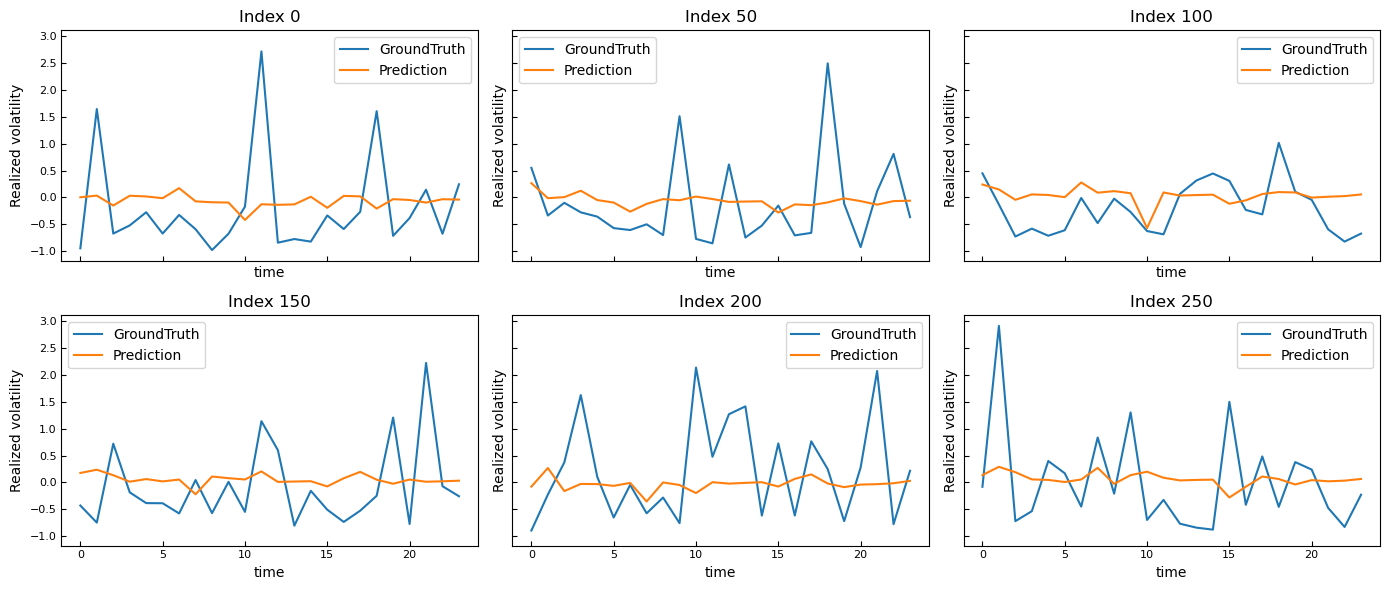

error metrics all  [{'mae': 0.7499916, 'mse': 0.9235629, 'rmse': 0.9610218, 'mape': 1.3733208, 'mspe': 192.55484}]
        mae       mse      rmse      mape       mspe
0  0.749992  0.923563  0.961022  1.373321  192.55484
[{'epoch': 1, 'train_steps': 80, 'train_loss': 1.0855681531131267, 'validation_loss': 1.0210048, 'test_loss': 0.94261175, 'cost_time': 28.71922278404236}, {'epoch': 2, 'train_steps': 80, 'train_loss': 1.0373628489673137, 'validation_loss': 1.00795, 'test_loss': 0.9289924, 'cost_time': 27.80018711090088}, {'epoch': 3, 'train_steps': 80, 'train_loss': 1.0285488948225976, 'validation_loss': 1.0067399, 'test_loss': 0.92645854, 'cost_time': 27.2773380279541}, {'epoch': 4, 'train_steps': 80, 'train_loss': 1.0250967845320702, 'validation_loss': 1.0048815, 'test_loss': 0.9247513, 'cost_time': 27.935680866241455}, {'epoch': 5, 'train_steps': 80, 'train_loss': 1.023732241243124, 'validation_loss': 0.9995437, 'test_loss': 0.9243279, 'cost_time': 27.30235004425049}, {'epoch': 6, '

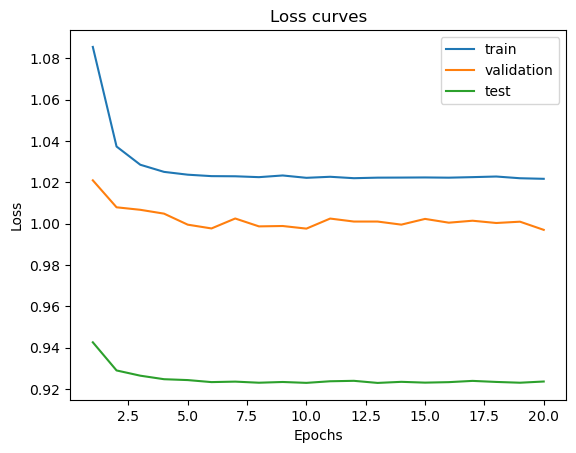

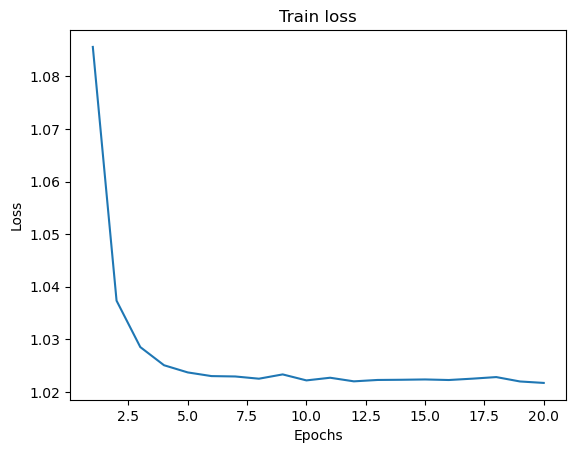

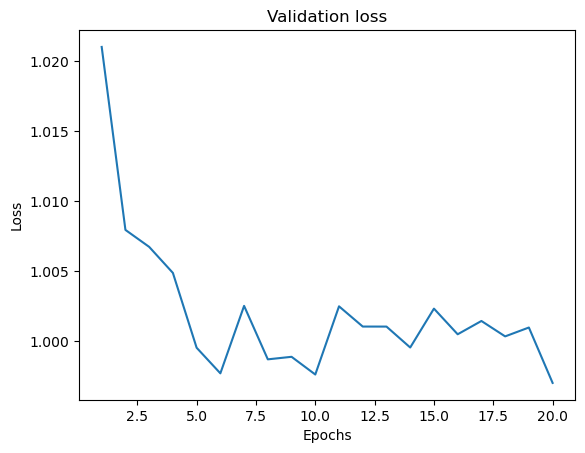

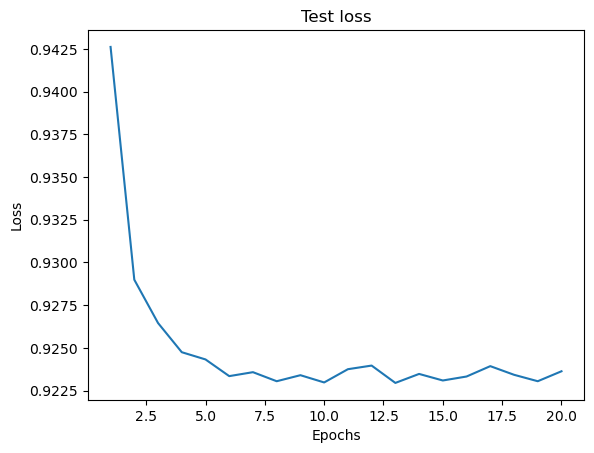

In [2]:
# make_directory(results_path)
# tcn targets with similar nature of stocks
run_experiments("tcn_targets", "similar", "M")

Args in experiment:
{'target_config_list_ms': [12, 12, 1], 'e_layers': 2, 'd_layers': 1, 'learning_rate': 1e-05, 'train_epochs': 20, 'model_id': 'similar_tcn_targets', 'root_path': '/Users/pujanmaharjan/uni adelaide/research project/realized-volatility/data/', 'features': 'MS', 'data_path': 'similar_stock_data_tcn_targets.csv', 'target': 'stock_0_y', 'is_time_id': True, 'model': 'informer', 'data': 'custom', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 12, 'dec_in': 12, 'c_out': 1, 'factor': 1, 'd_model': 512, 'n_heads': 8, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'fixed', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'patience': 100, 'des': 'exp', 'use_gpu': False, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'inverse': False, 'detail_freq': 'h'}
using 

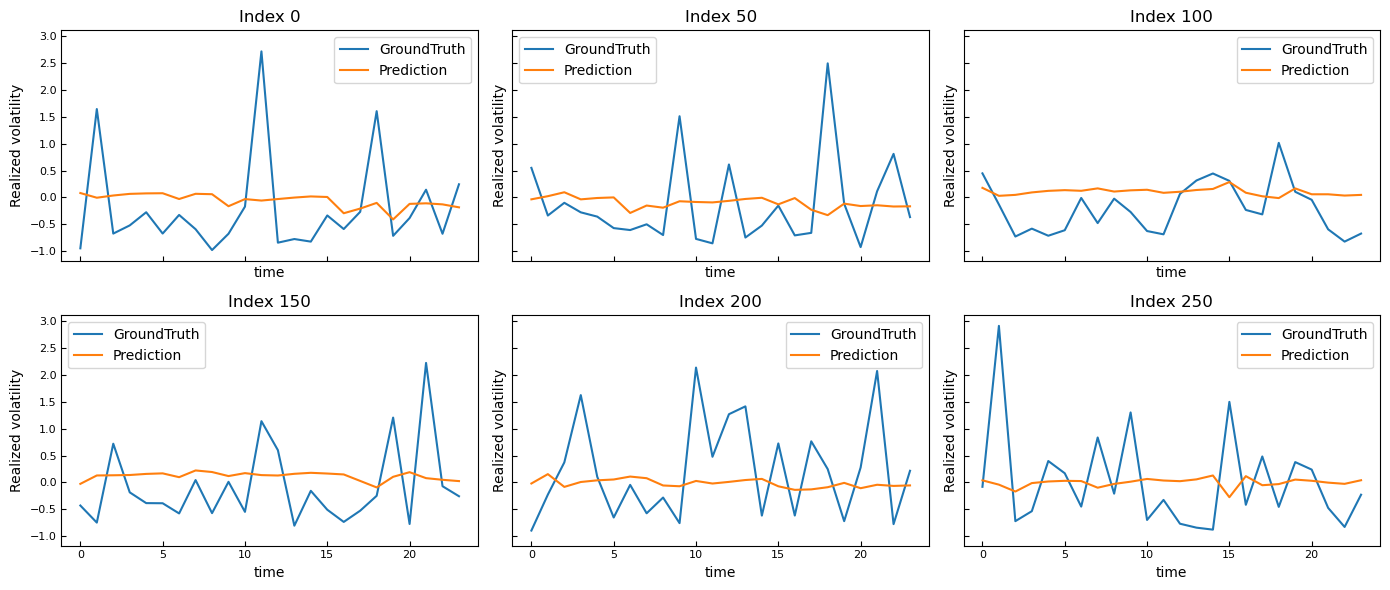

error metrics all  [{'mae': 0.63101125, 'mse': 0.74667346, 'rmse': 0.8641027, 'mape': 2.0561163, 'mspe': 775.3585}]
        mae       mse      rmse      mape        mspe
0  0.631011  0.746673  0.864103  2.056116  775.358521
[{'epoch': 1, 'train_steps': 80, 'train_loss': 1.0473321951925754, 'validation_loss': 0.80863327, 'test_loss': 0.7569909, 'cost_time': 27.670170068740845}, {'epoch': 2, 'train_steps': 80, 'train_loss': 1.0212098412215709, 'validation_loss': 0.81037575, 'test_loss': 0.750522, 'cost_time': 27.641955137252808}, {'epoch': 3, 'train_steps': 80, 'train_loss': 1.0091259971261024, 'validation_loss': 0.7975147, 'test_loss': 0.7466494, 'cost_time': 27.010056972503662}, {'epoch': 4, 'train_steps': 80, 'train_loss': 1.0070251680910587, 'validation_loss': 0.814115, 'test_loss': 0.7466727, 'cost_time': 27.774590015411377}, {'epoch': 5, 'train_steps': 80, 'train_loss': 1.0064572490751744, 'validation_loss': 0.8134951, 'test_loss': 0.7457419, 'cost_time': 27.94589900970459}, {'epoc

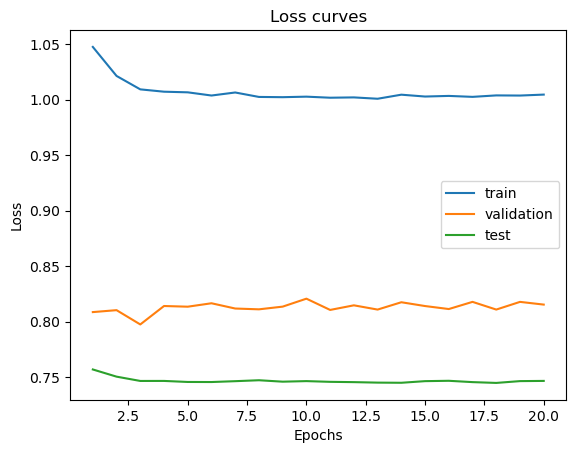

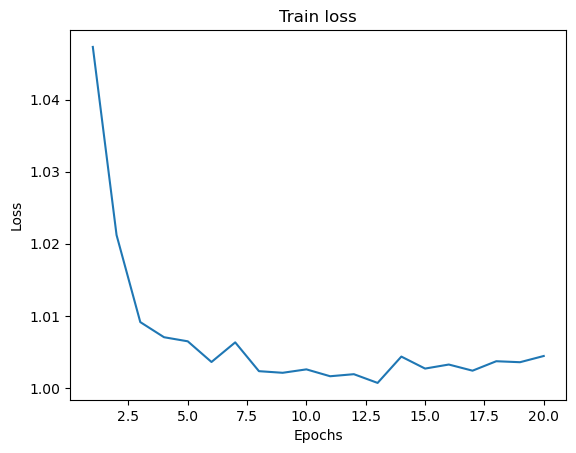

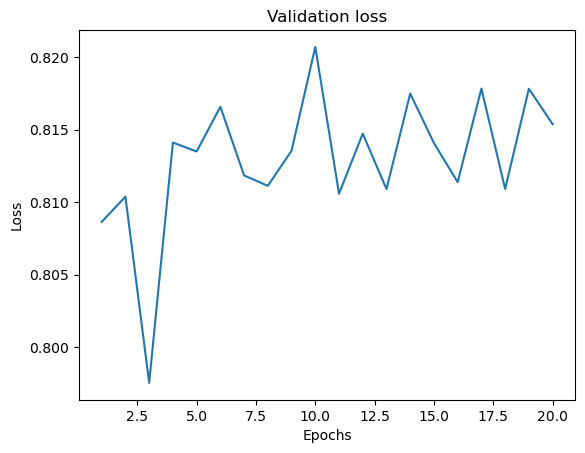

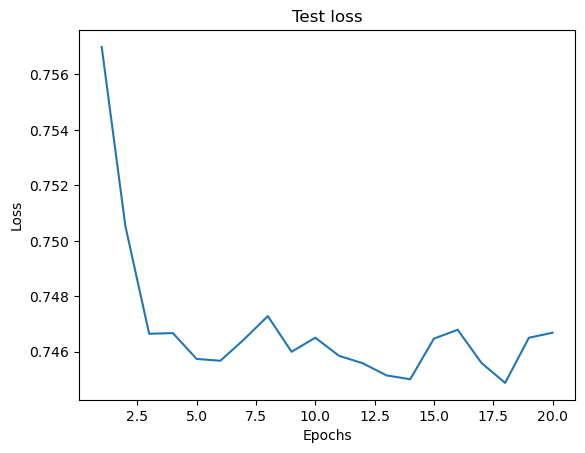

In [3]:
run_experiments("tcn_targets", "similar", "MS")

Args in experiment:
{'target_config_list_ms': [], 'e_layers': 2, 'd_layers': 1, 'learning_rate': 1e-05, 'train_epochs': 20, 'model_id': 'dissimilar_tcn_targets', 'root_path': '/Users/pujanmaharjan/uni adelaide/research project/realized-volatility/data/', 'features': 'M', 'data_path': 'dissimilar_stock_data_tcn_targets.csv', 'target': 'stock_0_y', 'target_config_list_m': [12, 12, 12], 'is_time_id': True, 'model': 'informer', 'data': 'custom', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 12, 'dec_in': 12, 'c_out': 12, 'factor': 1, 'd_model': 512, 'n_heads': 8, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'fixed', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'patience': 100, 'des': 'exp', 'use_gpu': False, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'inverse'

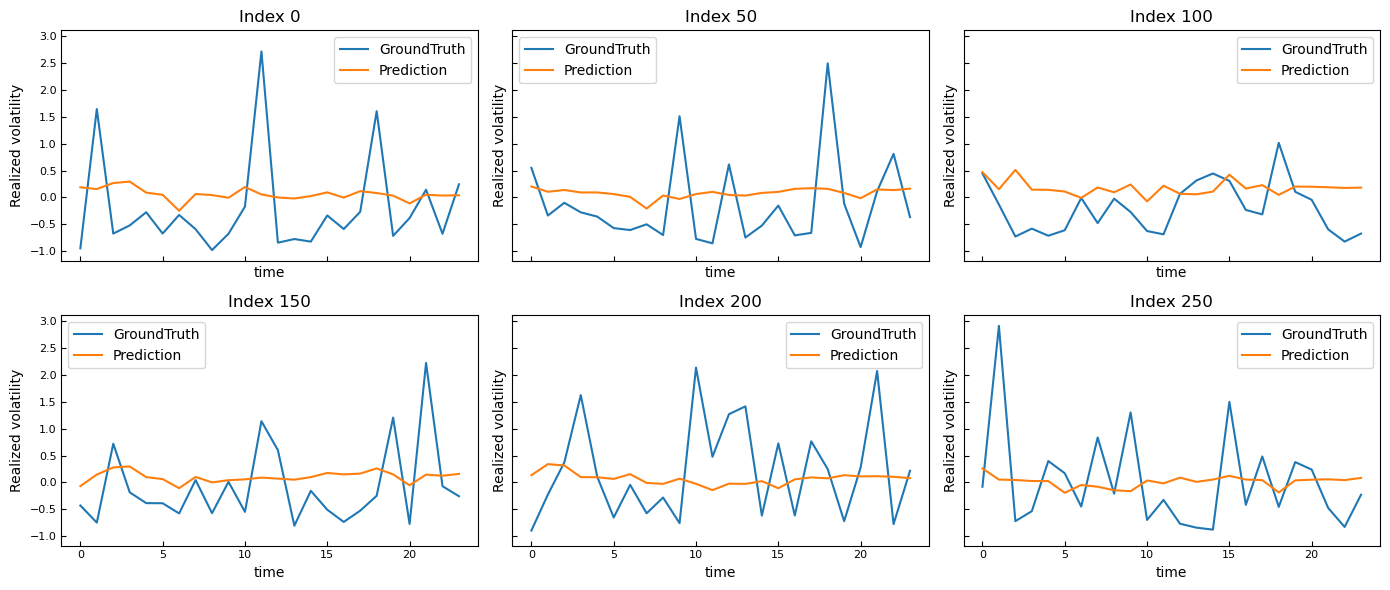

error metrics all  [{'mae': 0.79135936, 'mse': 1.0190871, 'rmse': 1.0094985, 'mape': 1.8516016, 'mspe': 539.1315}]
        mae       mse      rmse      mape       mspe
0  0.791359  1.019087  1.009498  1.851602  539.13147
[{'epoch': 1, 'train_steps': 80, 'train_loss': 1.0960164360702038, 'validation_loss': 1.1832982, 'test_loss': 1.0359823, 'cost_time': 28.25218391418457}, {'epoch': 2, 'train_steps': 80, 'train_loss': 1.0307733356952666, 'validation_loss': 1.1701423, 'test_loss': 1.0178968, 'cost_time': 27.868723154067993}, {'epoch': 3, 'train_steps': 80, 'train_loss': 1.021390749514103, 'validation_loss': 1.1593713, 'test_loss': 1.0193149, 'cost_time': 27.652902126312256}, {'epoch': 4, 'train_steps': 80, 'train_loss': 1.0174949780106544, 'validation_loss': 1.1715941, 'test_loss': 1.0202774, 'cost_time': 27.294301986694336}, {'epoch': 5, 'train_steps': 80, 'train_loss': 1.0156502299010755, 'validation_loss': 1.1647722, 'test_loss': 1.021712, 'cost_time': 27.228330850601196}, {'epoch': 6

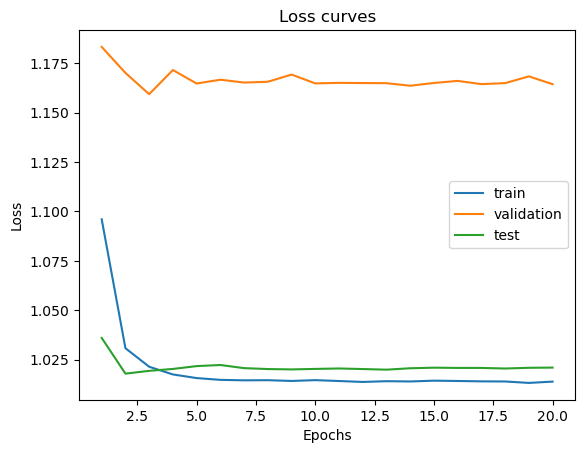

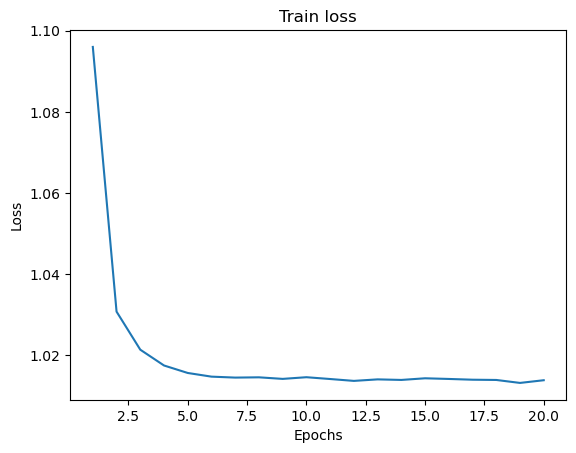

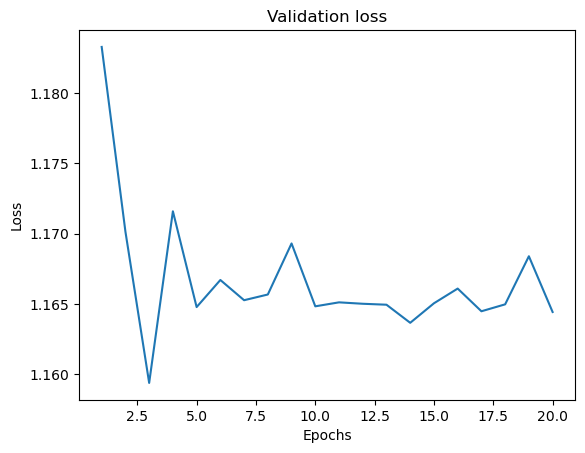

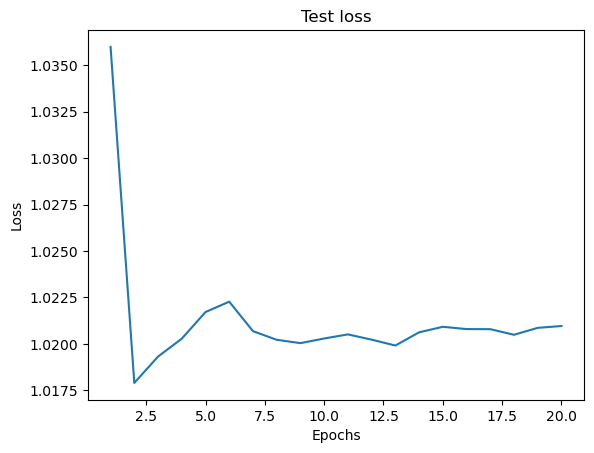

In [4]:
# tcn targets with similar nature of stocks
run_experiments("tcn_targets", "dissimilar", "M")

Args in experiment:
{'target_config_list_ms': [12, 12, 1], 'e_layers': 2, 'd_layers': 1, 'learning_rate': 1e-05, 'train_epochs': 20, 'model_id': 'dissimilar_tcn_targets', 'root_path': '/Users/pujanmaharjan/uni adelaide/research project/realized-volatility/data/', 'features': 'MS', 'data_path': 'dissimilar_stock_data_tcn_targets.csv', 'target': 'stock_0_y', 'is_time_id': True, 'model': 'informer', 'data': 'custom', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 12, 'dec_in': 12, 'c_out': 1, 'factor': 1, 'd_model': 512, 'n_heads': 8, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'fixed', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'patience': 100, 'des': 'exp', 'use_gpu': False, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'inverse': False, 'detail_freq': 'h'}


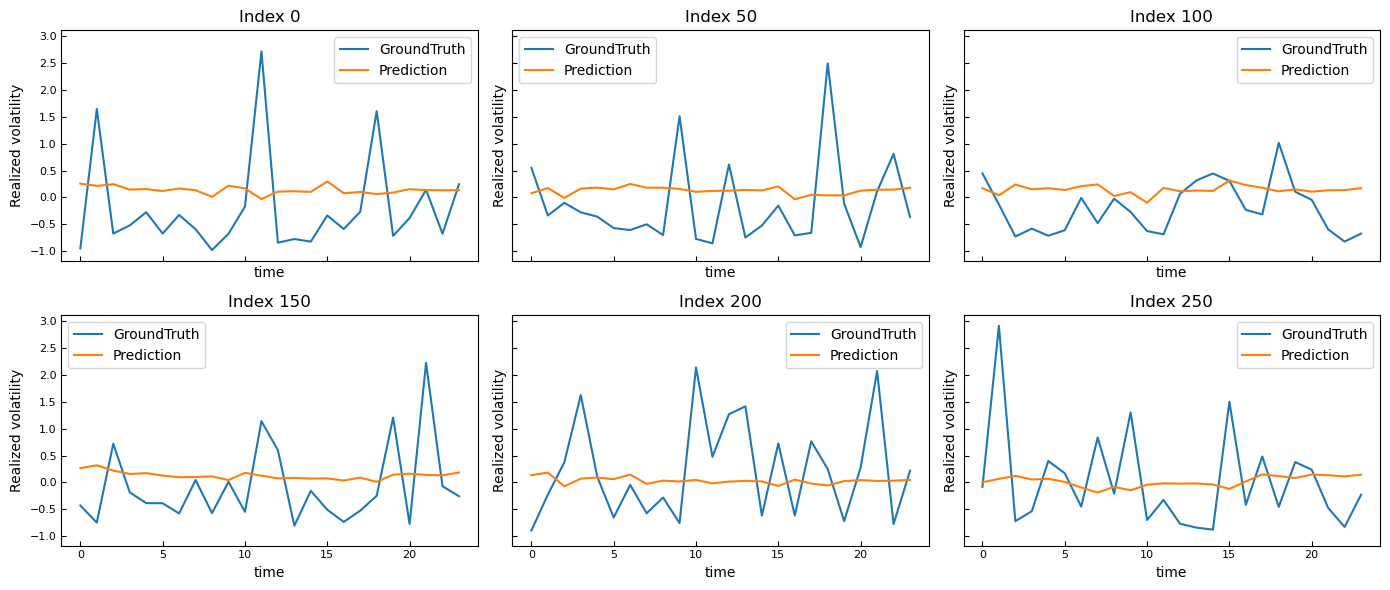

error metrics all  [{'mae': 0.661399, 'mse': 0.76048774, 'rmse': 0.87205946, 'mape': 2.6109197, 'mspe': 1450.2307}]
        mae       mse      rmse     mape         mspe
0  0.661399  0.760488  0.872059  2.61092  1450.230713
[{'epoch': 1, 'train_steps': 80, 'train_loss': 1.0702487103641034, 'validation_loss': 0.80359894, 'test_loss': 0.78685236, 'cost_time': 27.049765825271606}, {'epoch': 2, 'train_steps': 80, 'train_loss': 1.0196860417723657, 'validation_loss': 0.7991068, 'test_loss': 0.75226724, 'cost_time': 27.588420152664185}, {'epoch': 3, 'train_steps': 80, 'train_loss': 1.012948251515627, 'validation_loss': 0.8024956, 'test_loss': 0.78028464, 'cost_time': 27.504420042037964}, {'epoch': 4, 'train_steps': 80, 'train_loss': 1.007873570919037, 'validation_loss': 0.79744244, 'test_loss': 0.7633061, 'cost_time': 27.71494722366333}, {'epoch': 5, 'train_steps': 80, 'train_loss': 1.009033539891243, 'validation_loss': 0.7990444, 'test_loss': 0.7655888, 'cost_time': 27.286502838134766}, {'ep

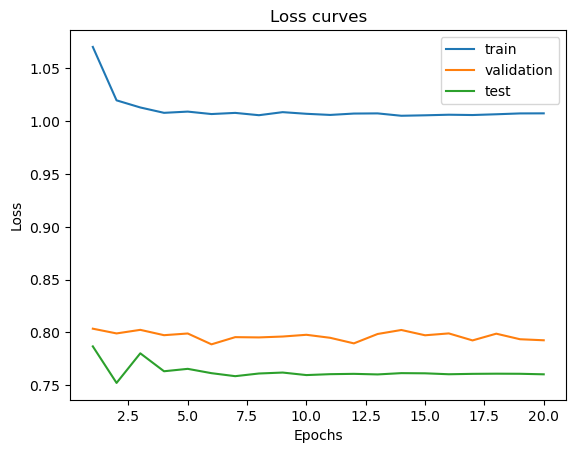

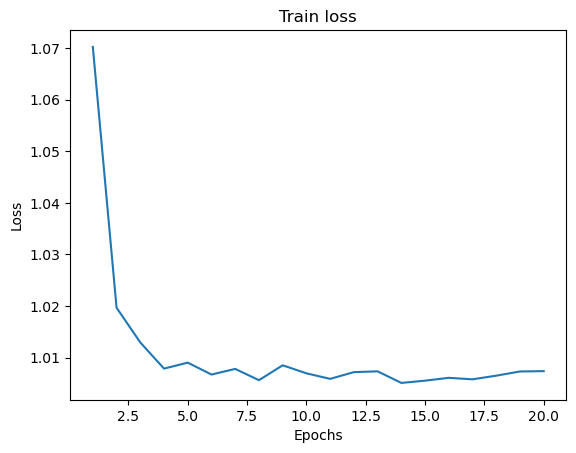

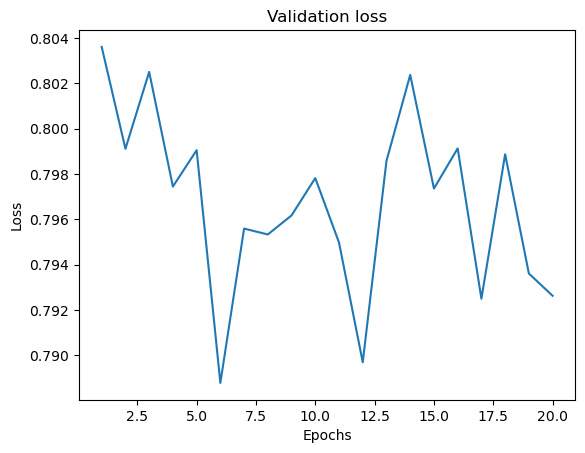

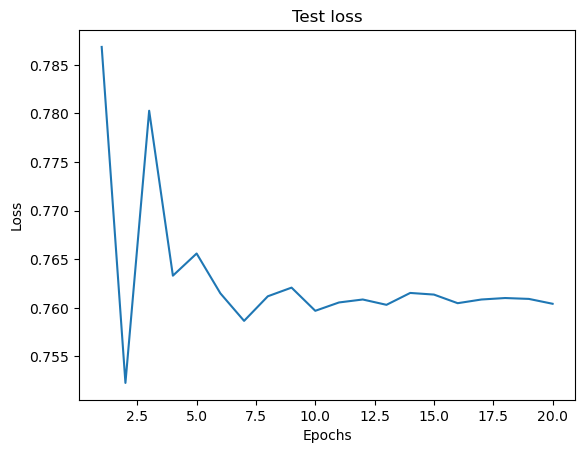

In [5]:
# tcn targets with similar nature of stocks
run_experiments("tcn_targets", "dissimilar", "MS")

Args in experiment:
{'target_config_list_ms': [14, 14, 1], 'e_layers': 2, 'd_layers': 1, 'learning_rate': 1e-05, 'train_epochs': 20, 'model_id': 'stock_0_features', 'root_path': '/Users/pujanmaharjan/uni adelaide/research project/realized-volatility/data/', 'features': 'MS', 'data_path': 'stock_data_basic_features_stock_0.csv', 'target': 'target', 'is_time_id': True, 'model': 'informer', 'data': 'custom', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 14, 'dec_in': 14, 'c_out': 1, 'factor': 1, 'd_model': 512, 'n_heads': 8, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'fixed', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'patience': 100, 'des': 'exp', 'use_gpu': False, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'inverse': False, 'detail_freq': 'h'}
using mps

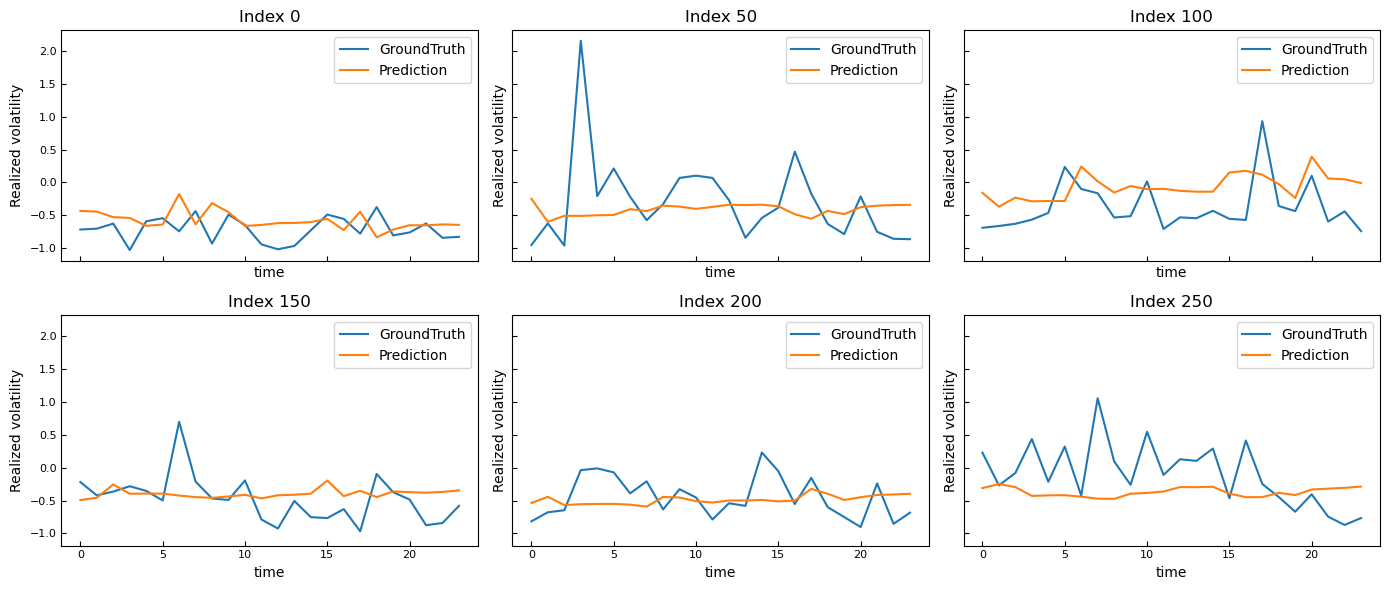

error metrics all  [{'mae': 0.43152878, 'mse': 0.40256023, 'rmse': 0.63447636, 'mape': 1.7121016, 'mspe': 46.134865}]
        mae      mse      rmse      mape       mspe
0  0.431529  0.40256  0.634476  1.712102  46.134865
[{'epoch': 1, 'train_steps': 80, 'train_loss': 0.6417603496462106, 'validation_loss': 0.27988487, 'test_loss': 0.50787795, 'cost_time': 28.33690094947815}, {'epoch': 2, 'train_steps': 80, 'train_loss': 0.5225742928683758, 'validation_loss': 0.21579127, 'test_loss': 0.46596006, 'cost_time': 27.844335794448853}, {'epoch': 3, 'train_steps': 80, 'train_loss': 0.48409971185028555, 'validation_loss': 0.20242871, 'test_loss': 0.3997431, 'cost_time': 27.38257908821106}, {'epoch': 4, 'train_steps': 80, 'train_loss': 0.47421283200383185, 'validation_loss': 0.20110613, 'test_loss': 0.4039758, 'cost_time': 27.452712774276733}, {'epoch': 5, 'train_steps': 80, 'train_loss': 0.46329931281507014, 'validation_loss': 0.19778353, 'test_loss': 0.40361267, 'cost_time': 27.468304872512817}

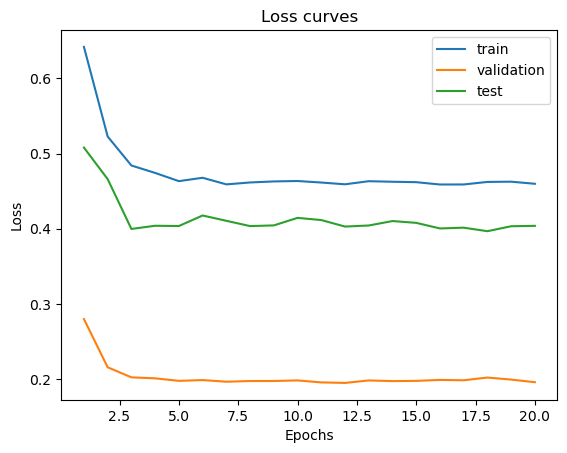

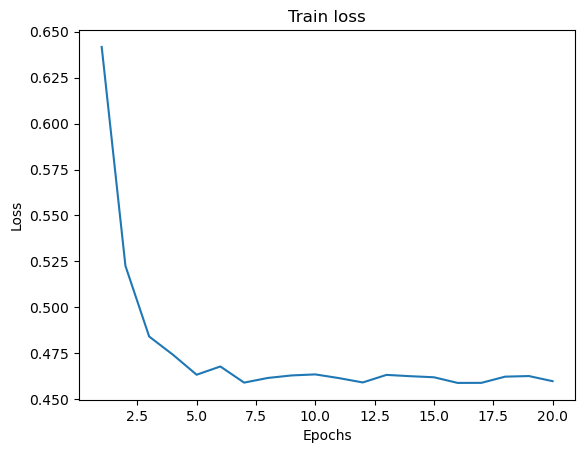

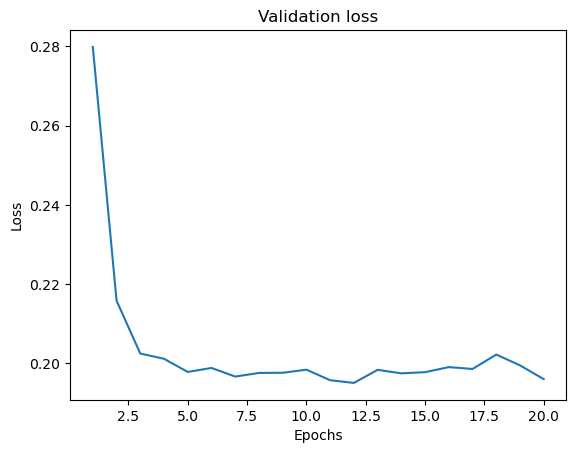

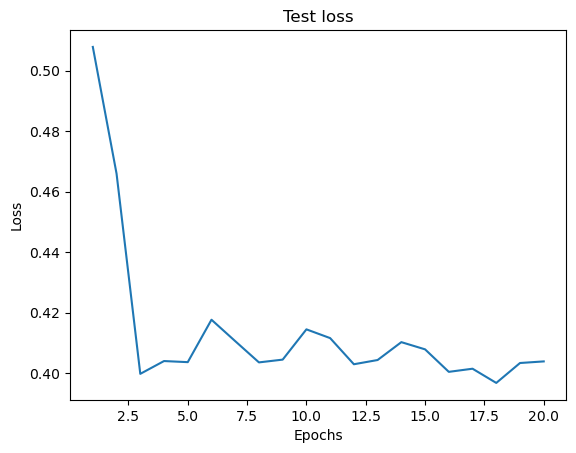

In [14]:
# tcn targets with similar nature of stocks
run_experiments("features", "stock_0", "MS")

In [10]:
# tcn targets with similar nature of stocks
run_experiments("targets", "stock_0", "S")

Args in experiment:
{'target_config_list_ms': [], 'e_layers': 2, 'd_layers': 1, 'learning_rate': 1e-05, 'train_epochs': 20, 'model_id': 'stock_0_targets', 'root_path': '/Users/pujanmaharjan/uni adelaide/research project/realized-volatility/data/', 'features': 'S', 'data_path': 'stocks_targets_0.csv', 'target': 'target', 'target_config_list_m': [1, 1, 1], 'is_time_id': True, 'model': 'informer', 'data': 'custom', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 1, 'dec_in': 1, 'c_out': 1, 'factor': 1, 'd_model': 512, 'n_heads': 8, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'fixed', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'patience': 100, 'des': 'exp', 'use_gpu': False, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'inverse': False, 'detail_freq': 'h'}
usin

KeyboardInterrupt: 